# <center> Exploratory Analysis for US Arrests Dataset with PCA and Clustering

Thre objective of this notebook is to explore the differences between various arrests in the USA using
unsupervised learning methods such as Principal Component Analysis (PCA) and
various clustering techniques.

This dataset is from the US Arrests Kaggle challenge ([link](https://www.kaggle.com/datasets/kurohana/usarrets)). A description of the
data is given as: “This data set contains statistics, in arrests per 100,000 residents,
for assault, murder, and rape in each of the 50 US states in 1973. Also given is the
percent of the population living in urban areas.”

## Import Libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage

# for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats 
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Read Data

In [2]:
# Load data
df = pd.read_csv('UsArrests.csv')

# view first 5 rows
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


## Explore Data

In [3]:
# check # of rows and columns
df.shape

(50, 5)

In [4]:
# check for missing values
df.isnull().sum()

City        0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

There are no missing values in our dataset. However, it is common when working with datasets to have missing values. 

If the missing valus are relatively low compared to our dataset these can be dropped. However if there were many missing values then a variety of techniques to fill in missing values can be implemented. Some of these are;

 - **Missing data imputation** - This uses a variety of statistical techniques such as the mean average or correlation trend analysis to impute the missing data. 
 
 - **Bagging** - For each variable, a bagged tree is created via all the other variables in the dataset. For every missing value, the appropriate bagged tree is used to predict the value.
 
 - **K-Nearest Neighbour (KNN) imputaion** - This is based on a variation of the Gower Distance. KNN will investigate other observations with similar values to all the other variables. After the identification, it will get the mean and impute the missing values.

In [5]:
# view column names and set to lowercase
df.columns = df.columns.str.lower()
df.columns

Index(['city', 'murder', 'assault', 'urbanpop', 'rape'], dtype='object')

In [6]:
# view statistics
stats = df.describe()

#select relevant rows
selected_stats = stats.loc[["mean","std","min","max"]].transpose()
selected_stats

,mean,std,min,max
murder,7.788,4.355510,0.8,17.4
assault,170.760,83.337661,45.0,337.0
urbanpop,65.540,14.474763,32.0,91.0
rape,21.232,9.366385,7.3,46.0


In [7]:
# explore data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   city      50 non-null     object 
 1   murder    50 non-null     float64
 2   assault   50 non-null     int64  
 3   urbanpop  50 non-null     int64  
 4   rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


To visualise the distribution of the observations for each feature, we plot histograms.

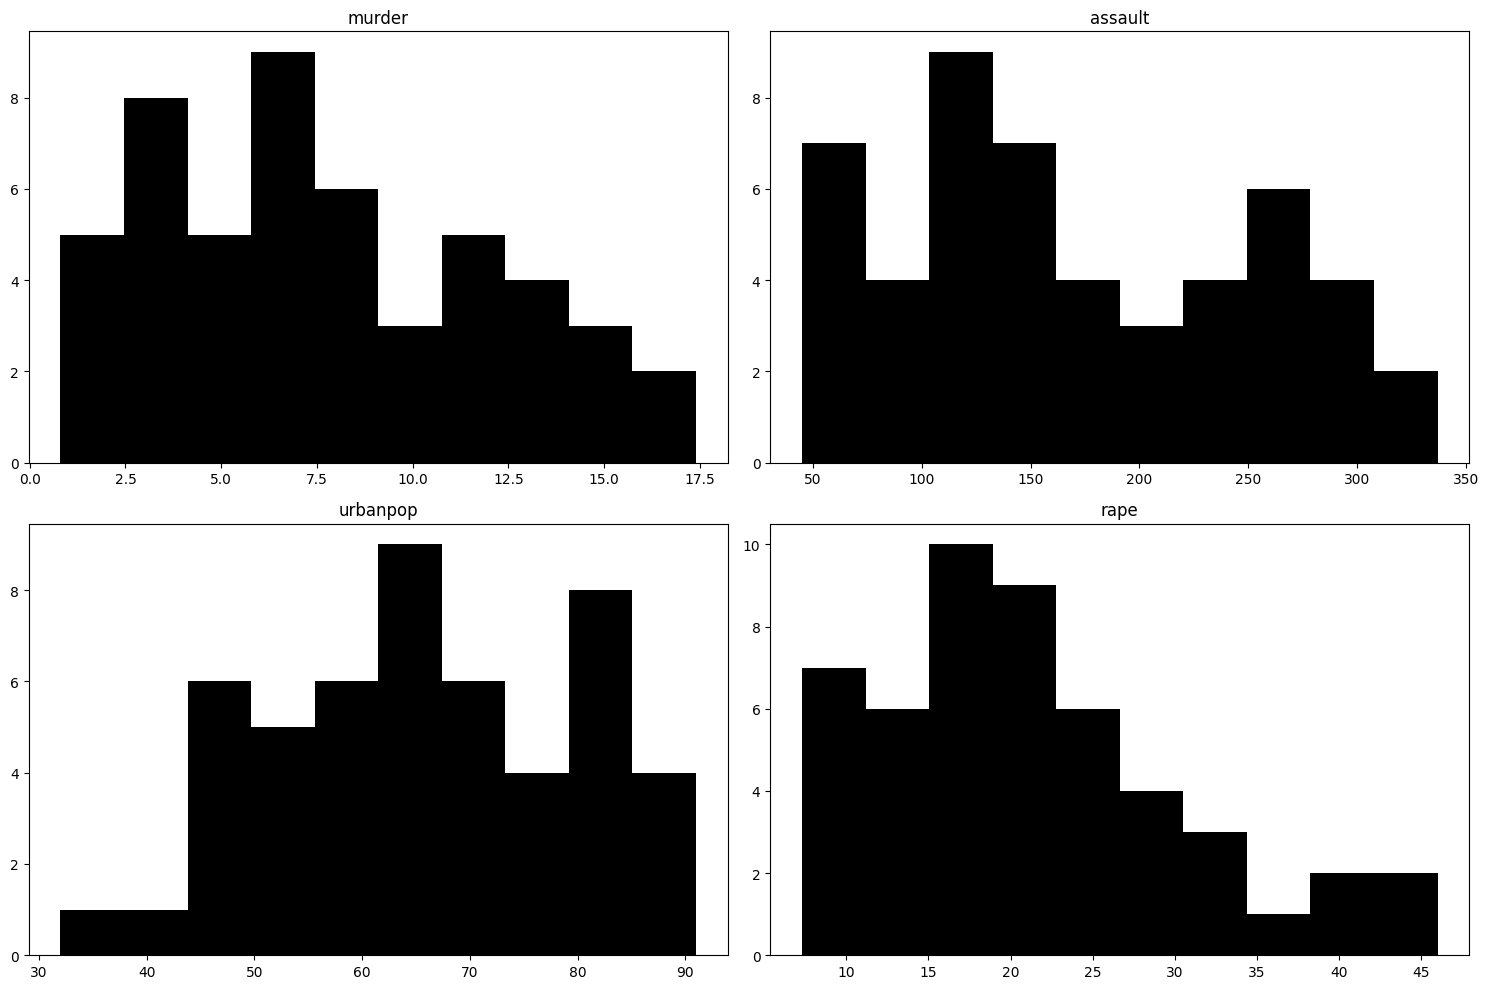

In [8]:
# Plot histograms
histograms = df.hist(color='black', grid=False, figsize=(15, 10)) #This can also be done for each column individually by calling hist on that column
plt.tight_layout()
plt.show()


From visual examination of the histplots we can draw some conclusions;

 - Arrests for assault is the most prevalent amongst the crimes
 - Arrests for rape follows a very similar trend to assualt, suggestion some correlation between the two. The highest frequency was between 16-20 with almost 20 states documenting this number of arrests.
 - Arrests for urbanpop had a highest count around 85-90, however the largest number of states for this feature was between 62 to 67 arrests.
 - Arrests for murder had the highest frequency between 6 and 8 on average, with over 8 states accounting for this number.

We can compile the tabular information we have so far into a single dataframe:

In [9]:
# Create summary table
missing = df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
frames = [relevant_missing,selected_stats]
summary = pd.concat(frames, axis=1)
summary.rename(columns = {0:"missing"}, inplace = True)
summary.to_csv('summary.csv', index=True) 
summary


,missing,mean,std,min,max
city,0,NaN,NaN,NaN,NaN
murder,0,7.788,4.355510,0.8,17.4
assault,0,170.760,83.337661,45.0,337.0
urbanpop,0,65.540,14.474763,32.0,91.0
rape,0,21.232,9.366385,7.3,46.0


## Correlation Analysis

We can use a correlation heatmap to view the positive and negative relationships between the features of our dataset.

To analyse the correlation of our coefficient heatmap, we look at each value. Each value in the matrix lies between -1 and 1. If it is:

 - 1: this means **Highest positive correlation** (i.e., the higher one value
gets, the higher the other value gets). This needs to be removed in the data.

 - 0: This means **little to no correlation between features.** This is the ideal case.

 - -1: This means **Highest negative correlation between features** (i.e., the
lower one value gets, the higher the other gets). This also needs to be removed.

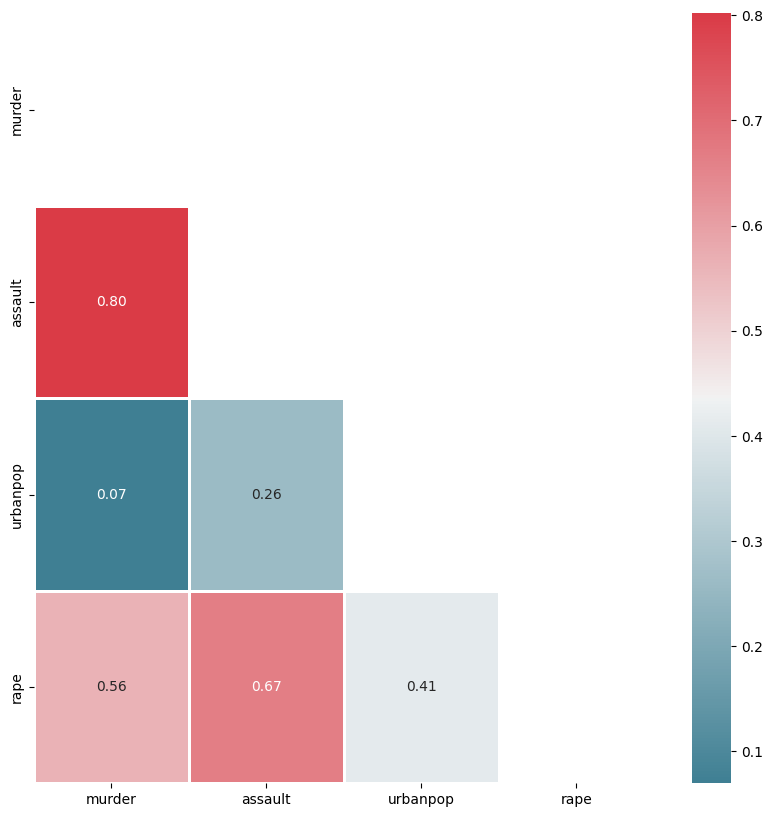

In [10]:
# create correlation heatmap

colormap = sns.diverging_palette(220, 10, as_cmap=True)

def corr_heatmap(df):
  # get correlations
  corrs = df.corr()

  # pick appropriate palette for heatmap

  # Plot figsize
  fig, ax = plt.subplots(figsize=(10, 10))

  # to mask mirrored side of heatmap
  dropSelf = np.zeros_like(corrs)
  dropSelf[np.triu_indices_from(dropSelf)] = True

  # Generate Heat Map, with annotations of the correlation strength and 2-decimal floats
  ax = sns.heatmap(corrs, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf, linewidth=2)

  plt.show()

corr_heatmap(df)


From the correlation matrix we can see that assault and murder have a very high positive correlation value of 0.8 suggesting that a lot of the assault arrests may have also come with a murder charge. The same hypotheses can be suggested between rape and assault as this has a positive correlation of 0.67, indicating that some assault charges may have resulted from an arrest due to rape.

## Apply PCA

In [11]:
# run PCA
np.set_printoptions(precision=2)

X = df.drop(["city"],axis=1).values.squeeze()

pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.802164,11.448007,-2.494933,2.407901
1,92.827450,17.982943,20.126575,-4.094047
2,124.068216,-8.830403,-1.687448,-4.353685
3,18.340035,16.703911,0.210189,-0.520994
4,107.422953,-22.520070,6.745873,-2.811826


The transformed version of the data, shows that the principle components are uncorrelated, meaning that PCA has summarised all related information into a smaller number of variables.                                      

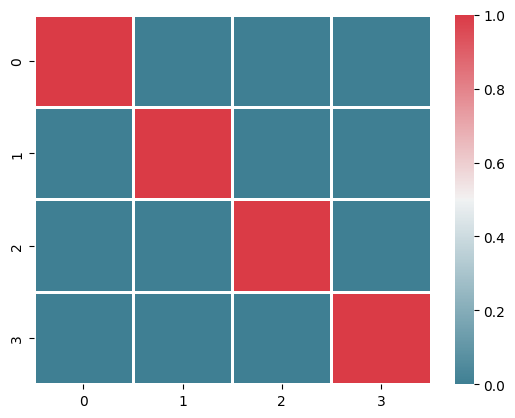

In [12]:
# create PCA correlation heatmap
ax = sns.heatmap(df_pca.corr(), cmap=colormap,linewidth=1);


## Interpreting PCA

Below is a summary of our dataset statistically after applying PCA;

In [13]:
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")

Standard deviation: [83.73 14.21  6.49  2.48]


In [14]:
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")

Proportion of Variance Explained: [9.66e-01 2.78e-02 5.80e-03 8.49e-04]


In [15]:
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_)}")

Cumulative Proportion: [7011.11 7213.11 7255.22 7261.38]


### Original Data

In [16]:
# re-load dataset for original data comparison
df = pd.read_csv('UsArrests.csv')

df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [17]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = df['City'][i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

    # Adapted from: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html

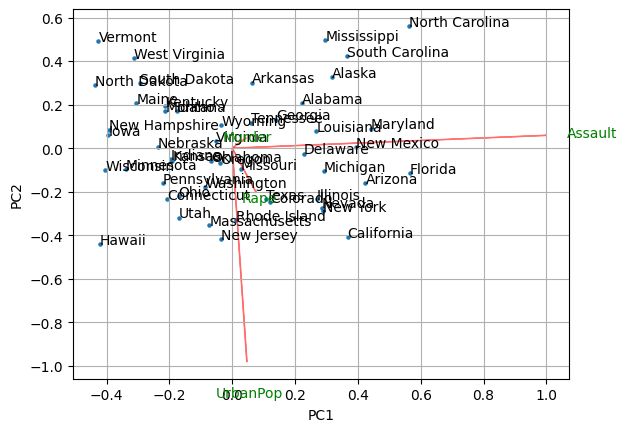

In [18]:
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(df.columns[1:5]))
plt.show()

Each point on a biplot is the projected observation, transformed from the original data. The importance of each feature is indicated by the length of the arrows on the biplot. This corresponds to the magnitude of the values in the eigenvectors.

This information can also be quantified as follows:

In [19]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(df.columns[1:5])
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.042,0.045
1,Assault,0.995,0.059
2,UrbanPop,0.046,0.977
3,Rape,0.075,0.201


### Standardised Data

We standardise data to ensure that certain features do no overbear others thus we scale them to have equal weighting.

In [20]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


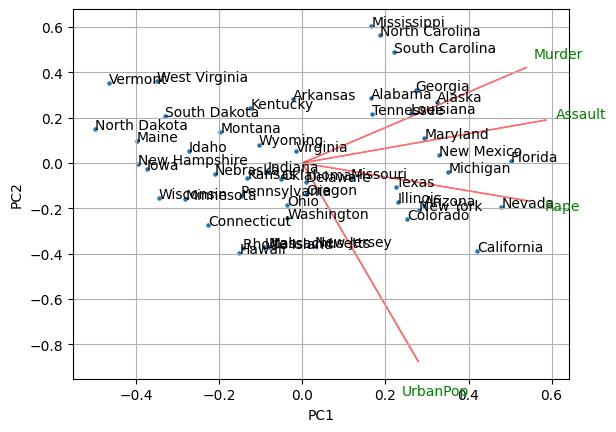

In [21]:
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(df.columns[1:]))
plt.show()

We see that the standardised data results in far more variables being utilised to explain the variance, as the large numbers no longer dominate it. We also see that the different features cluster together in groups.

In [22]:
# Feature importance

pc1 = abs( std_pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( std_pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(df.columns[1:5])
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


Inspecting the feature importance now, we see that the three variables, 'Murder', 'Assault' and 'Rape' contribute fairly evenly, whereas 'UrbanPop' is fairly low.

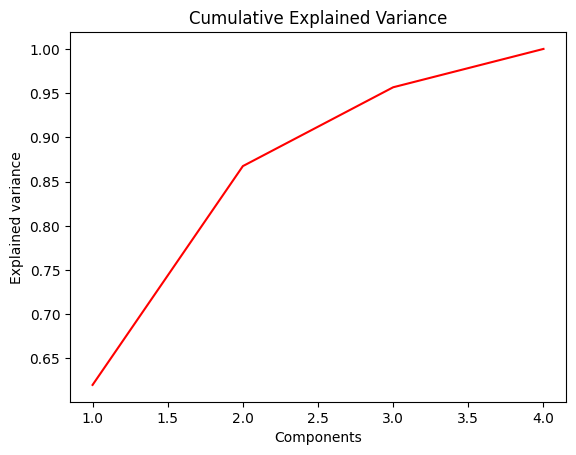

In [23]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance");

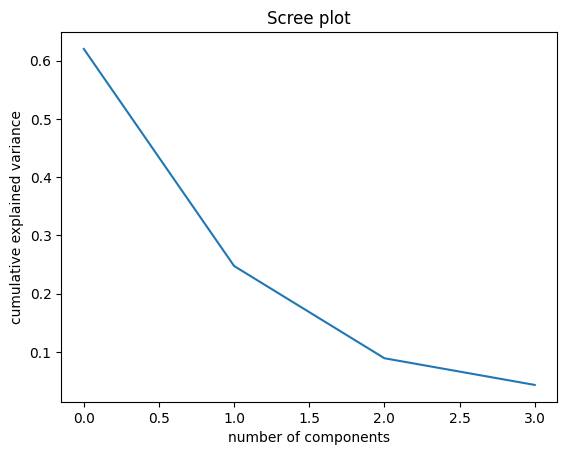

In [24]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot");

## Interpretation

1.The first principal component explains just over 60% of the variance in the data, whereas the second principal component explains around 25%. So, the first two principal components together account for about 85% of the variance present in the data.

2.Inspecting the scree plot, we see There is an ‘elbow’ after the second component. The third principal component explains less than ten percent of the variance in the data, and the fourth principal component explains less than half that and so is essentially redundant.

3.Inspecting the biplot, we can see that the first loading vector places approximately equal weight on Assault, Murder, and Rape, with much less weight on UrbanPop. Hence this component roughly corresponds to a measure of overall rates of the crimes. 

4.The second loading vector places most of its weight on UrbanPop and much less weight on the other three features. Hence, this component roughly corresponds to the level of urbanization of the state. 

5.Overall, we see that the crime-related variables (Murder, Assault, and Rape) are located close to each other, and that the UrbanPop variable is far from the other three. This indicates that the crime-related variables are correlated with each other—states with high murder rates tend to have high assault and rape rates—and that the UrbanPop variable is less correlated with the other three.

6.States with large positive scores on the first component, such as California, Nevada and Florida, have high crime rates, while states like North Dakota, with negative scores on the first component, have low crime rates. 

7.California also has a high score on the second component, indicating a high level of urbanisation, while the opposite is true for states like Mississippi.

8.States close to zero on both components, such as Indiana, have approximately average levels of both crime and urbanization.

## Hierarchical Clustering

Hierarchical clustering, also known as hierarchical cluster analysis, is an algorithm that groups similar objects into groups called clusters. The endpoint is a set of clusters, where each cluster is distinct from each other cluster, and the objects within each cluster are broadly similar to each other.

In [25]:
# re-load dataset for original data
df = pd.read_csv('UsArrests.csv')

# run PCA
pca_df = pd.DataFrame(X_std_trans[:,0:5], index = df.index)
pca_df.head()


,0,1,2,3
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


### Dendrograms

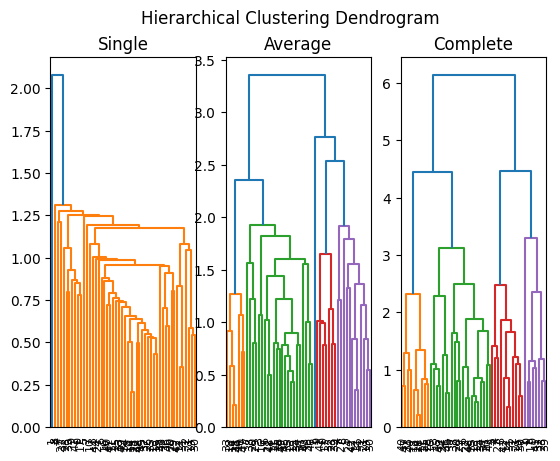

In [26]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3);

The complete linkage appears to show the best distinction in the clusters with the greatest variance between the lengths of the links. From the dendrogram below we can see the suggestion of 3 to 4 clusters.

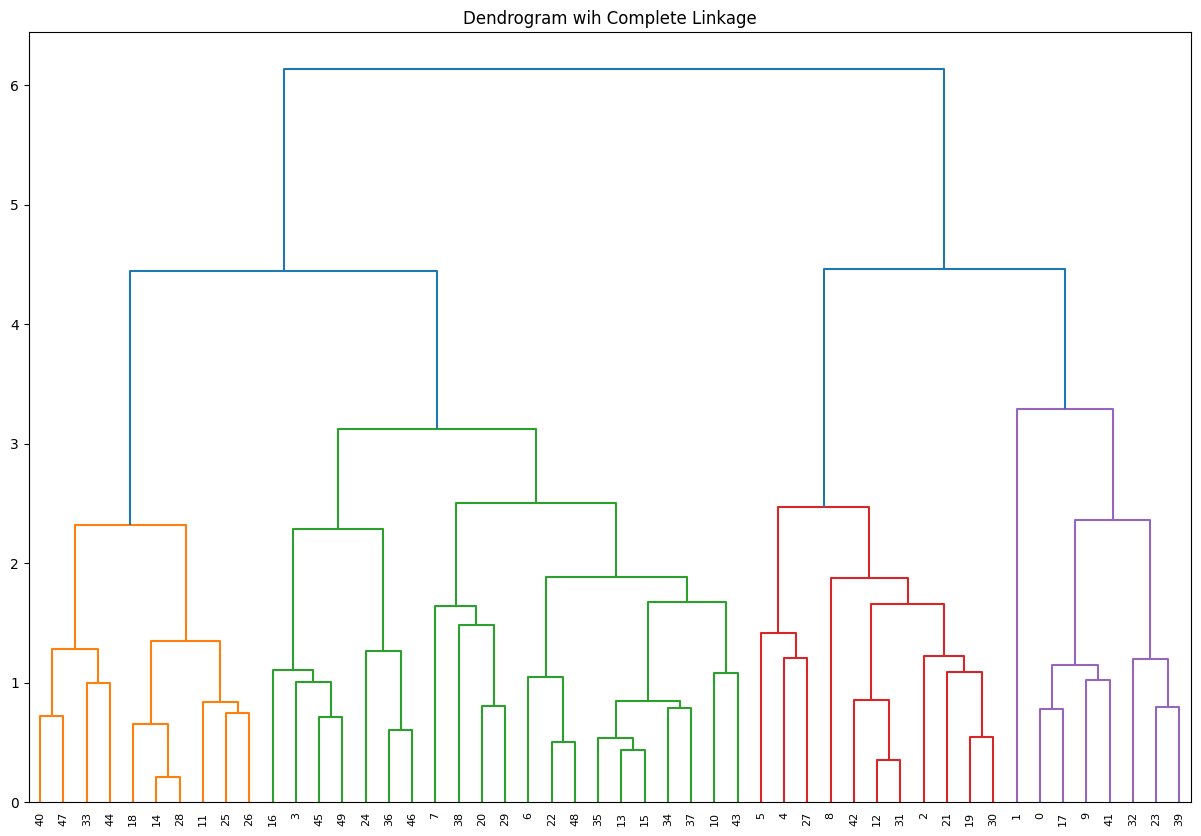

In [27]:
plt.figure(figsize=(15,10))
plt.title('Dendrogram wih Complete Linkage')
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index);



### K-means Clustering

K-means is a clustering partitioning algorithm that is fast and efficient and scales well for large datasets. It is an iterative process, so observations can switch between clusters while the algorithm runs until it converges at a local optimum. This method is not robust when it comes to noise data and outliers and it is necessary to specify K in advance.

For our analysis, it seems that the shape of clusters is likely to be regular based on the PCA biplot. K will be set to 3. A visualisation of the clusters is shown in the figure below.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


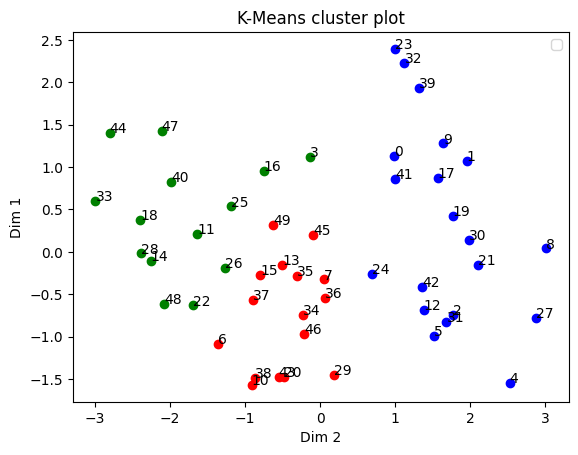

In [28]:
from sklearn.cluster import KMeans

# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=3
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = df.index[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend();

**Link to Github Profile:**
